# Basic being Bayesian by backpropagation

In [1]:
import nbloader
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from demo_correlatedFields import fields
from demo_util import nzr,gpusession
from demo_tf_sample import bbb
print ("Packages Loaded")

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Importing Jupyter notebook from [demo_correlatedFields.ipynb]
Importing Jupyter notebook from [demo_util.ipynb]
Importing Jupyter notebook from [demo_tf_sample.ipynb]
Packages loaded
TF version: 1.3.0
Packages Loaded


Construct graph

In [2]:
class bayesianNetwork(object):
    def __init__(self,_xdim=2,_ydim=1,_hdims=[32,16],_actv=tf.nn.relu,
                _bn=slim.batch_norm,_sess=None,_VERBOSE=False):
        # Parse inputs
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdims = _hdims
        self.actv = _actv
        self.bn = _bn
        self.sess = _sess
        self.VERBOSE = _VERBOSE
        # Initialize graph
        self.init_randomWeights()
        self.construct_graph()
        
    def init_randomWeights(self):
        self.Qweights,self.Qbiases,self.Pweights,self.Pbiases = [],[],[],[]
        for lIdx in range(len(self.hdims)+1):
            if lIdx == 0: # Input to hidden
                _shape = [self.xdim,self.hdims[0]]
            elif lIdx < len(self.hdims): # Hidden to hidden
                _shape = [self.hdims[lIdx-1],self.hdims[lIdx]]
            else: # Hidden to output
                _shape = [self.hdims[-1],self.ydim]
            self.Qweights.append(bbb(_name='Qw%d'%lIdx,_distribution='Gaussian',
                                 _shape=_shape,_trainable=True,_VERBOSE=self.VERBOSE))
            self.Qbiases.append(bbb(_name='Qb%d'%lIdx,_distribution='Gaussian',
                                     _shape=[_shape[1]],_trainable=True,_VERBOSE=self.VERBOSE))
            self.Pweights.append(bbb(_name='Pw%d'%lIdx,_distribution='Gaussian',
                                     _shape=_shape,_trainable=False,_VERBOSE=self.VERBOSE))
            self.Pbiases.append(bbb(_name='Pb%d'%lIdx,_distribution='Gaussian',
                                     _shape=[_shape[1]],_trainable=False,_VERBOSE=self.VERBOSE))

    def construct_graph(self):
        # Feeding input and output placeholders
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim],name='Input')
        self.y = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim],name='Output')
        # Construct stochastic forward path 
        self.nx = tf.shape(self.x)[0] # number of inputs
        self.x_rsh = tf.reshape(self.x,shape=[-1,self.xdim,1])
        self.net = self.x_rsh
        for lIdx in range(len(self.hdims)+1):
            _w_rsh = tf.reshape(self.Qweights[lIdx].sampler,shape=
                               [-1,self.Qweights[lIdx].shape[1],self.Qweights[lIdx].shape[0]])
            _b_rsh = tf.reshape(self.Qbiases[lIdx].sampler,shape=
                               [-1,self.Qbiases[lIdx].shape[0],1])
            self.net = tf.matmul(_w_rsh,self.net)+_b_rsh # [None x self.hdims[0] x 1]
            if lIdx == len(self.hdims):
                self.net = self.net
            else:
                self.net = self.actv(self.net)
        # Define loss function
        self.out = tf.reshape(self.net,[-1,self.ydim])
        self.err_sq = tf.pow(self.out-self.y,2)
        self.err_sq_rdc = tf.reduce_mean(self.err_sq,axis=1)
        self.loss = tf.reduce_mean(self.err_sq_rdc)
        self.optm = tf.train.AdamOptimizer(
            learning_rate=0.001,beta1=0.9,beta2=0.99,epsilon=1e-8)\
            .minimize(self.loss)
        
    
    # Stochastic forward path
    def stochastic_forwardPath(self,_x):
        nData = _x.shape[0]
        # Feed input
        feeds = {self.x:_x}
        # Feed nData to all weights
        for hIdx in range(len(self.hdims)+1):
            feeds[self.Qweights[hIdx].nSample] = nData
            feeds[self.Qbiases[hIdx].nSample] = nData
        return self.sess.run(self.net,feed_dict=feeds)
    
    # Train 
    def train(self,_x,_y,_maxEpoch=1000,_batchSize=128,_printPeriod=100,_plotPeriod=100,
             _lr=1e-4):
        # Number of training data
        nData = _x.shape[0] 
        # mini-batch training
        maxIter = max(nData // _batchSize, 1)
        for epoch in range(_maxEpoch):
            for i in range(maxIter):
                xBatch = _x[i*_batchSize:(i+1)*_batchSize,:]
                yBatch = _y[i*_batchSize:(i+1)*_batchSize,:]
                nBatch = xBatch.shape[0]
                # Feed input 
                feeds = {self.x:xBatch,self.y:yBatch}
                for hIdx in range(len(self.hdims)+1):
                    feeds[self.Qweights[hIdx].nSample] = nBatch
                    feeds[self.Qbiases[hIdx].nSample] = nBatch
                # Run train
                _,loss = self.sess.run([self.optm,self.loss],feed_dict=feeds)
            if (epoch%_printPeriod)==0:
                print("[%d/%d] loss : %.3e"%(epoch,_maxEpoch,loss))
        
print ("Class defined")

Class defined


Instantiate 'bayesianNetwork' object

In [3]:
sess = gpusession()
BN = bayesianNetwork(_xdim=2,_ydim=1,_hdims=[32,16],_actv=tf.nn.tanh,
                     _bn=slim.batch_norm,_sess=sess,_VERBOSE=False)
sess.run(tf.global_variables_initializer())
print ("bayesianNetwork instantiated.")
print 'BN.net:',BN.net
# Test the graph
nData = 10
x = np.random.rand(nData,2)
net = BN.stochastic_forwardPath(x)
print 'x.shape:',x.shape,'net.shape:',net.shape

bayesianNetwork instantiated.
BN.net: Tensor("add_38:0", shape=(?, 1, 1), dtype=float32)
x.shape: (10, 2) net.shape: (10, 1, 1)


Make correlated field

X.shape: (50, 2)
Y.shape: (50, 1)


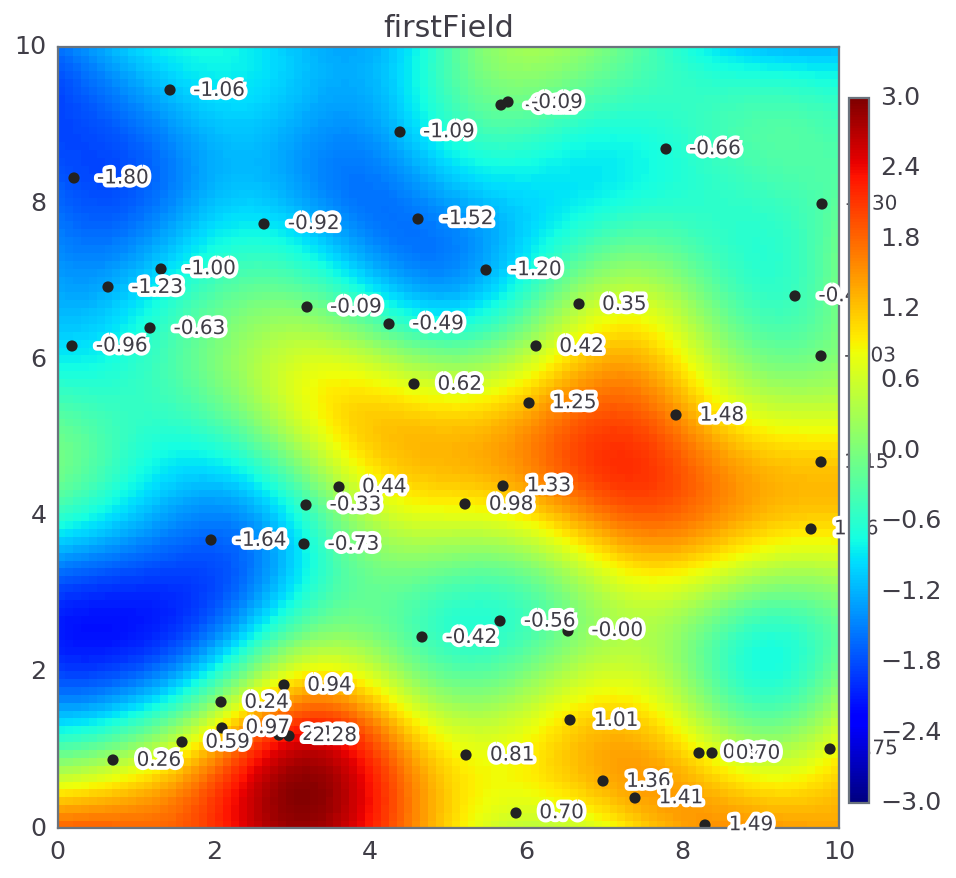

In [4]:
F = fields(_name='fields',_VERBOSE=False,
           _axisInfo=np.array([0,10,0,10]),
           _resFineInfo=np.array([100,100]),
           _resCoarseInfo=np.array([20,20]),
           _nField=10)
levs = np.array([[1,1,1,1,0,0,0,-1,-1,-1]]).astype(np.float).T
hyp = {'gain':1,'len':1/2.,'s2w':1e-10}
F.genCorrelatedFields(_levs=levs,_rseed=0,_hyp=hyp)
F.getMeasurements(_nMeas=50,_rseed=0)
F.getAccumulatedMeas()
# Use first field
firstField = F.fields[0]
firstField.plotField(_figsize=(7,7),_title='firstField',
                     _PLOT_COARSE=False,_PLOT_MEAS=True)
X = firstField.xyFineMeas
Y = firstField.zFineMeas
print 'X.shape:',X.shape
print 'Y.shape:',Y.shape

Train

In [6]:
BN.train(X,Y,_maxEpoch=1000,_batchSize=5,_printPeriod=10,_plotPeriod=10,_lr=1e-4)

[0/1000] loss : 8.917e+00
[10/1000] loss : 7.382e+00
[20/1000] loss : 6.613e+00
[30/1000] loss : 8.160e+00
[40/1000] loss : 4.551e+00
[50/1000] loss : 6.409e+00
[60/1000] loss : 1.798e+01
[70/1000] loss : 1.326e+01
[80/1000] loss : 3.139e+00
[90/1000] loss : 7.795e+00
[100/1000] loss : 1.663e+00
[110/1000] loss : 4.246e+00
[120/1000] loss : 6.268e+00
[130/1000] loss : 1.146e+00
[140/1000] loss : 7.681e+00
[150/1000] loss : 7.995e+00
[160/1000] loss : 6.204e+00
[170/1000] loss : 7.515e+00
[180/1000] loss : 2.556e+00
[190/1000] loss : 5.803e+00
[200/1000] loss : 7.937e+00
[210/1000] loss : 2.092e+00
[220/1000] loss : 1.402e+00
[230/1000] loss : 6.975e-01
[240/1000] loss : 1.219e+00
[250/1000] loss : 9.959e+00
[260/1000] loss : 6.051e+00
[270/1000] loss : 2.027e+00
[280/1000] loss : 2.735e+00
[290/1000] loss : 2.736e+00
[300/1000] loss : 6.869e-01
[310/1000] loss : 6.876e+00
[320/1000] loss : 2.284e+00
[330/1000] loss : 4.139e+00
[340/1000] loss : 2.506e+00
[350/1000] loss : 3.001e+00
[36